In [1]:
import wrangle as w
import wrangle_Naomi
import env

import pandas as pd
import numpy as np
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

from importlib import reload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
reload(w)
df = w.wrangle_zillow()

In [3]:
df.shape

(77368, 34)

In [4]:
train, validate, test = w.tvt_split(df)

In [5]:
print("train observations: ", train.shape)
print("validate observations: ", validate.shape)
print("test observations: ", test.shape)

train observations:  (43325, 34)
validate observations:  (18569, 34)
test observations:  (15474, 34)


In [6]:
train.log_error.isnull().sum()

0

# explore

### Does having nice outdoor features have a relationship with logerror?

### Unscaled

In [7]:
train.head()

,parcel_id,bath_count,bed_count,calc_bath_and_bed,calc_sqft,finished_sqft12,fips,fireplace_count,full_bath_count,garage_car_count,...,land_value,tax_amount,census_tract_and_block,log_error,transaction_date,heating_system_desc,property_land_use_desc,log_error_outliers,outliers,bound_group
8691,14280708,2.5,4,2.5,2660,2660,6059,0,2,2,...,842407,11496.12,60590631031015,-0.039439,2017-02-09,<NA>,Single Family Residential,,in_range,in
55904,11481831,1.0,3,1.0,1023,1023,6037,0,1,0,...,195922,4070.09,60376023011010,-0.013036,2017-07-12,Floor/Wall,Single Family Residential,,in_range,in
60354,12972815,1.0,2,1.0,896,896,6037,0,1,0,...,98082,2572.99,60374301023003,0.028698,2017-07-26,Central,Condominium,,in_range,in
65303,12857173,2.0,4,2.0,1949,1949,6037,0,2,0,...,153471,3985.98,60374085033012,-0.034356,2017-08-11,Central,Planned Unit Development,,in_range,in
67572,14302532,2.0,3,2.0,1492,1492,6059,0,2,2,...,536514,6596.28,60590525261004,0.094583,2017-08-18,<NA>,Single Family Residential,,in_range,in


In [8]:
X3 = train[['garage_car_count', 'pool_count', 'lot_sqft']]

In [9]:
kmeans = KMeans(n_clusters = 4, random_state= 89).fit(X3)
train['cluster3'] = kmeans.predict(X3)

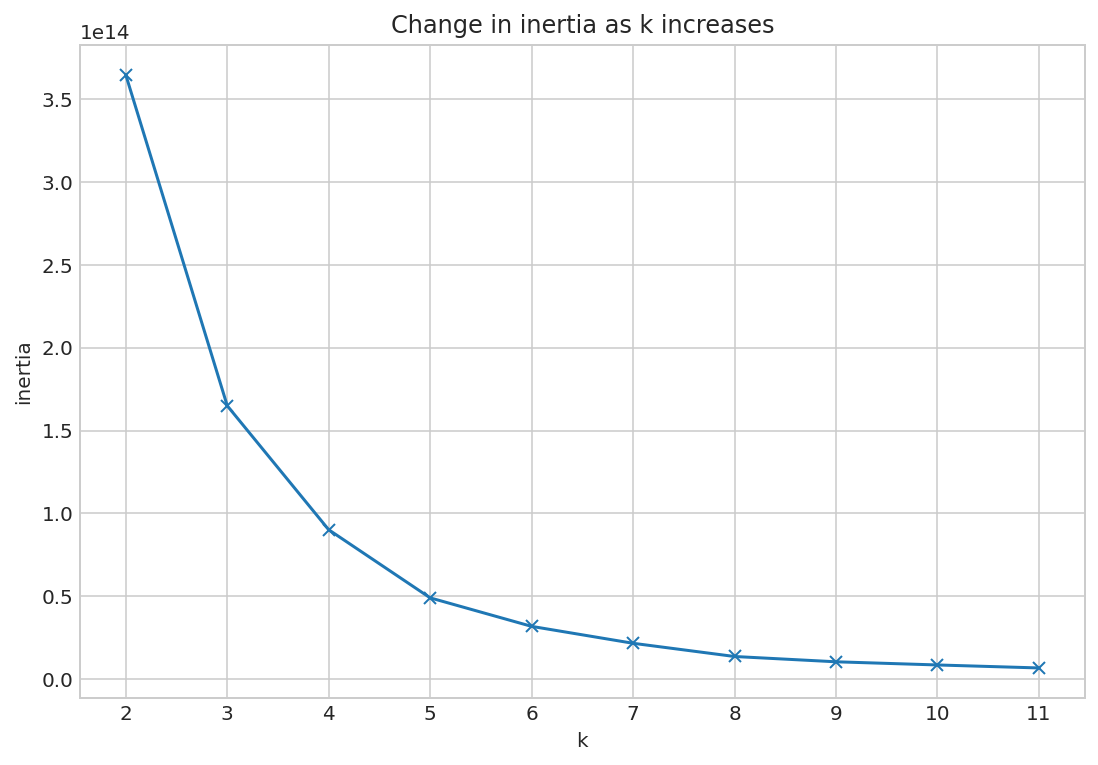

In [10]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X3).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [11]:
train.groupby('cluster3')['garage_car_count', 'pool_count', 'lot_sqft'].mean()

/var/folders/h3/mf3_948d1xn0mgz6l997fvlw0000gn/T/ipykernel_45763/887977046.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train.groupby('cluster3')['garage_car_count', 'pool_count', 'lot_sqft'].mean()


,garage_car_count,pool_count,lot_sqft
cluster3,,,
0,0.618198,0.195802,12463.793199
1,0.02069,0.441379,1140642.606897
2,0.0,0.0,6971010.0
3,0.022853,0.536704,306840.822715


<AxesSubplot:xlabel='cluster3', ylabel='log_error'>

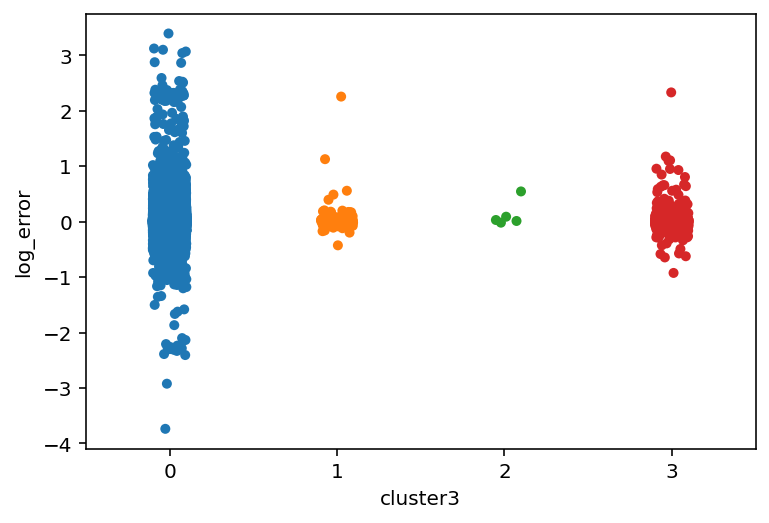

In [12]:
sns.stripplot(data = train, x = 'cluster3', y = 'log_error')

### Scaled

In [13]:
train_scaled3 = w.scale(train, ['garage_car_count', 'pool_count', 'lot_sqft'])
train_scaled3.head()

,scaled_garage_car_count,scaled_pool_count,scaled_lot_sqft
8691,0.181818,1.0,0.001356
55904,0.000000,1.0,0.000758
60354,0.000000,0.0,0.013073
65303,0.000000,0.0,0.000723
67572,0.181818,0.0,0.000807


In [14]:
extracted_col = train['log_error']

In [15]:
X3_scaled = train_scaled3[['scaled_garage_car_count', 'scaled_pool_count', 'scaled_lot_sqft']]

In [16]:
X3_scaled.head()

,scaled_garage_car_count,scaled_pool_count,scaled_lot_sqft
8691,0.181818,1.0,0.001356
55904,0.000000,1.0,0.000758
60354,0.000000,0.0,0.013073
65303,0.000000,0.0,0.000723
67572,0.181818,0.0,0.000807


In [17]:
kmeans = KMeans(n_clusters = 4, random_state = 89).fit(X3_scaled)
train_scaled3['cluster3_scaled'] = kmeans.predict(X3_scaled)

In [18]:
train_scaled3['log_error'] = train['log_error']

In [19]:
train_scaled3.head()

,scaled_garage_car_count,scaled_pool_count,scaled_lot_sqft,cluster3_scaled,log_error
8691,0.181818,1.0,0.001356,3,-0.039439
55904,0.000000,1.0,0.000758,1,-0.013036
60354,0.000000,0.0,0.013073,0,0.028698
65303,0.000000,0.0,0.000723,0,-0.034356
67572,0.181818,0.0,0.000807,2,0.094583


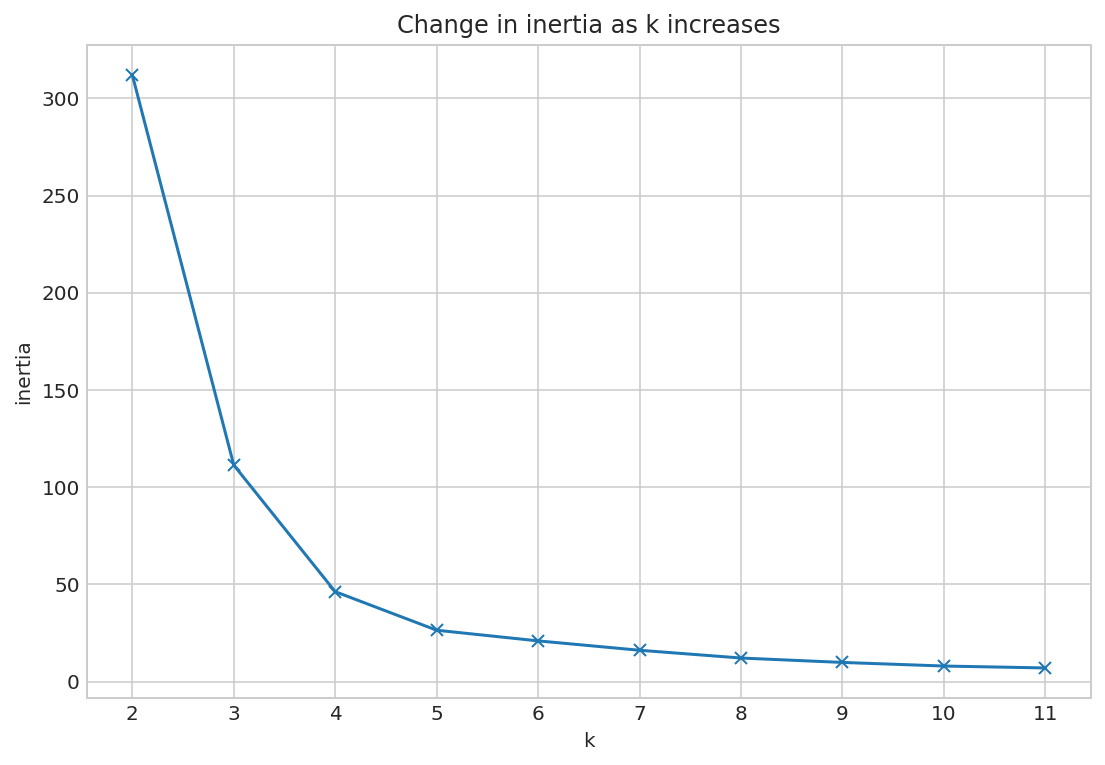

In [20]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X3_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [21]:
train_scaled3.groupby('cluster3_scaled')['scaled_garage_car_count', 'scaled_pool_count', 'scaled_lot_sqft'].mean()

/var/folders/h3/mf3_948d1xn0mgz6l997fvlw0000gn/T/ipykernel_45763/2461689130.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_scaled3.groupby('cluster3_scaled')['scaled_garage_car_count', 'scaled_pool_count', 'scaled_lot_sqft'].mean()


,scaled_garage_car_count,scaled_pool_count,scaled_lot_sqft
cluster3_scaled,,,
0,0.000000,0.0,0.003923
1,0.002735,1.0,0.009658
2,0.161352,0.0,0.000716
3,0.199592,1.0,0.001913


In [22]:
train_scaled3.head()

,scaled_garage_car_count,scaled_pool_count,scaled_lot_sqft,cluster3_scaled,log_error
8691,0.181818,1.0,0.001356,3,-0.039439
55904,0.000000,1.0,0.000758,1,-0.013036
60354,0.000000,0.0,0.013073,0,0.028698
65303,0.000000,0.0,0.000723,0,-0.034356
67572,0.181818,0.0,0.000807,2,0.094583


<AxesSubplot:xlabel='cluster3_scaled', ylabel='log_error'>

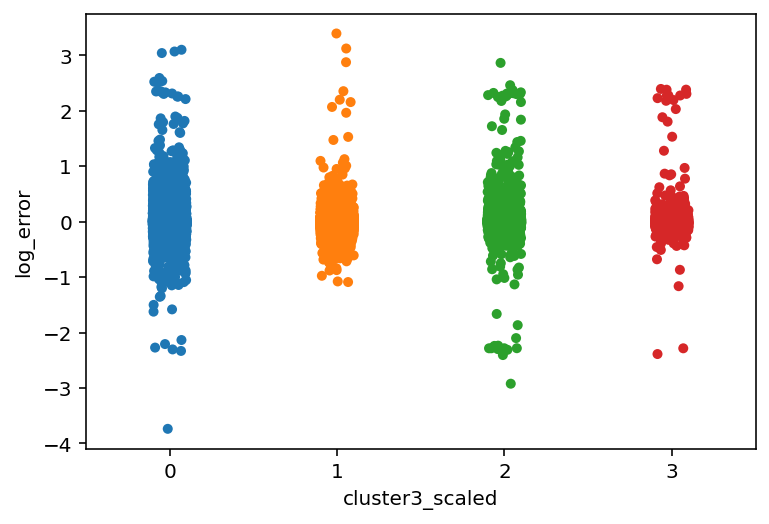

In [23]:
sns.stripplot(data = train_scaled3, x = 'cluster3_scaled', y = 'log_error')

Text(0.5, 1.0, 'Scaled')

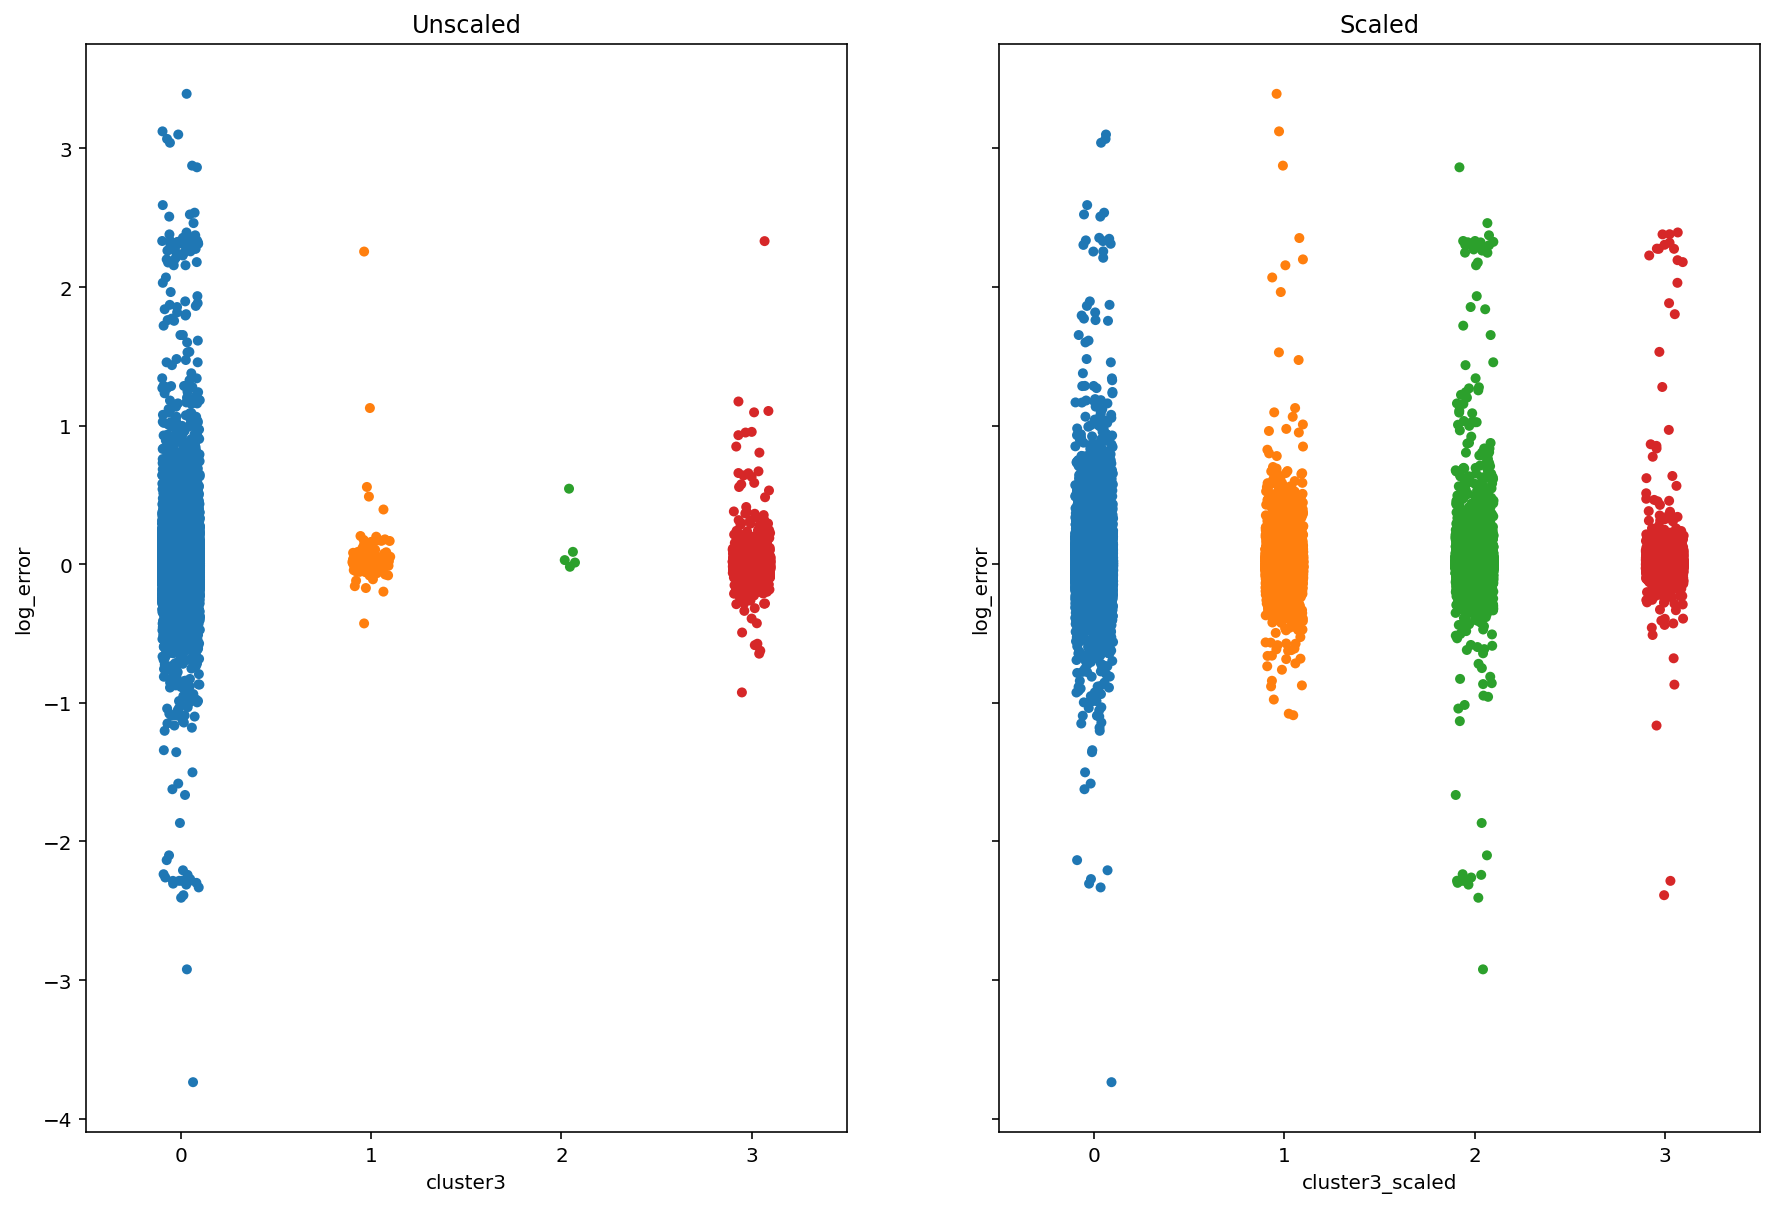

In [24]:
fig, axes= plt.subplots(1,2, figsize =(15, 10), sharey = True)
fig.subtitle = ('Unscaled vs. Scaled')

#Unscaled
sns.stripplot(ax=axes[0], data = train, x = 'cluster3', y = 'log_error')
axes[0].set_title('Unscaled')

#Scaled
sns.stripplot(ax = axes[1],data = train_scaled3, x = 'cluster3_scaled', y = 'log_error')
axes[1].set_title('Scaled')

In [25]:
def viz_for_Q3(train_df):
    
    #unscaled data
    X3 = train[['garage_car_count', 'pool_count', 'lot_sqft']]
    kmeans = KMeans(n_clusters = 4, random_state = 89).fit(X3)
    train['cluster3'] = kmeans.predict(X3)
    
    #scaled data
    train_scaled3 = w.scale(train, ['garage_car_count', 'pool_count', 'lot_sqft'])
    X3_scaled = train_scaled3[['scaled_garage_car_count', 'scaled_pool_count', 'scaled_lot_sqft']]
    kmeans = KMeans(n_clusters = 4, random_state = 89).fit(X3_scaled)
    train_scaled3['cluster3_scaled'] = kmeans.predict(X3_scaled)
    train_scaled3['log_error'] = train['log_error']
    
    #viz 
    fig, axes= plt.subplots(1,2, figsize =(15, 10), sharey = True)
    fig.subtitle = ('Unscaled vs. Scaled')

    #Unscaled
    sns.stripplot(ax=axes[0], data = train, x = 'cluster3', y = 'log_error')
    axes[0].set_title('Unscaled')

    #Scaled
    sns.stripplot(ax = axes[1],data = train_scaled3, x = 'cluster3_scaled', y = 'log_error')
    axes[1].set_title('Scaled')
    
    plt.show()

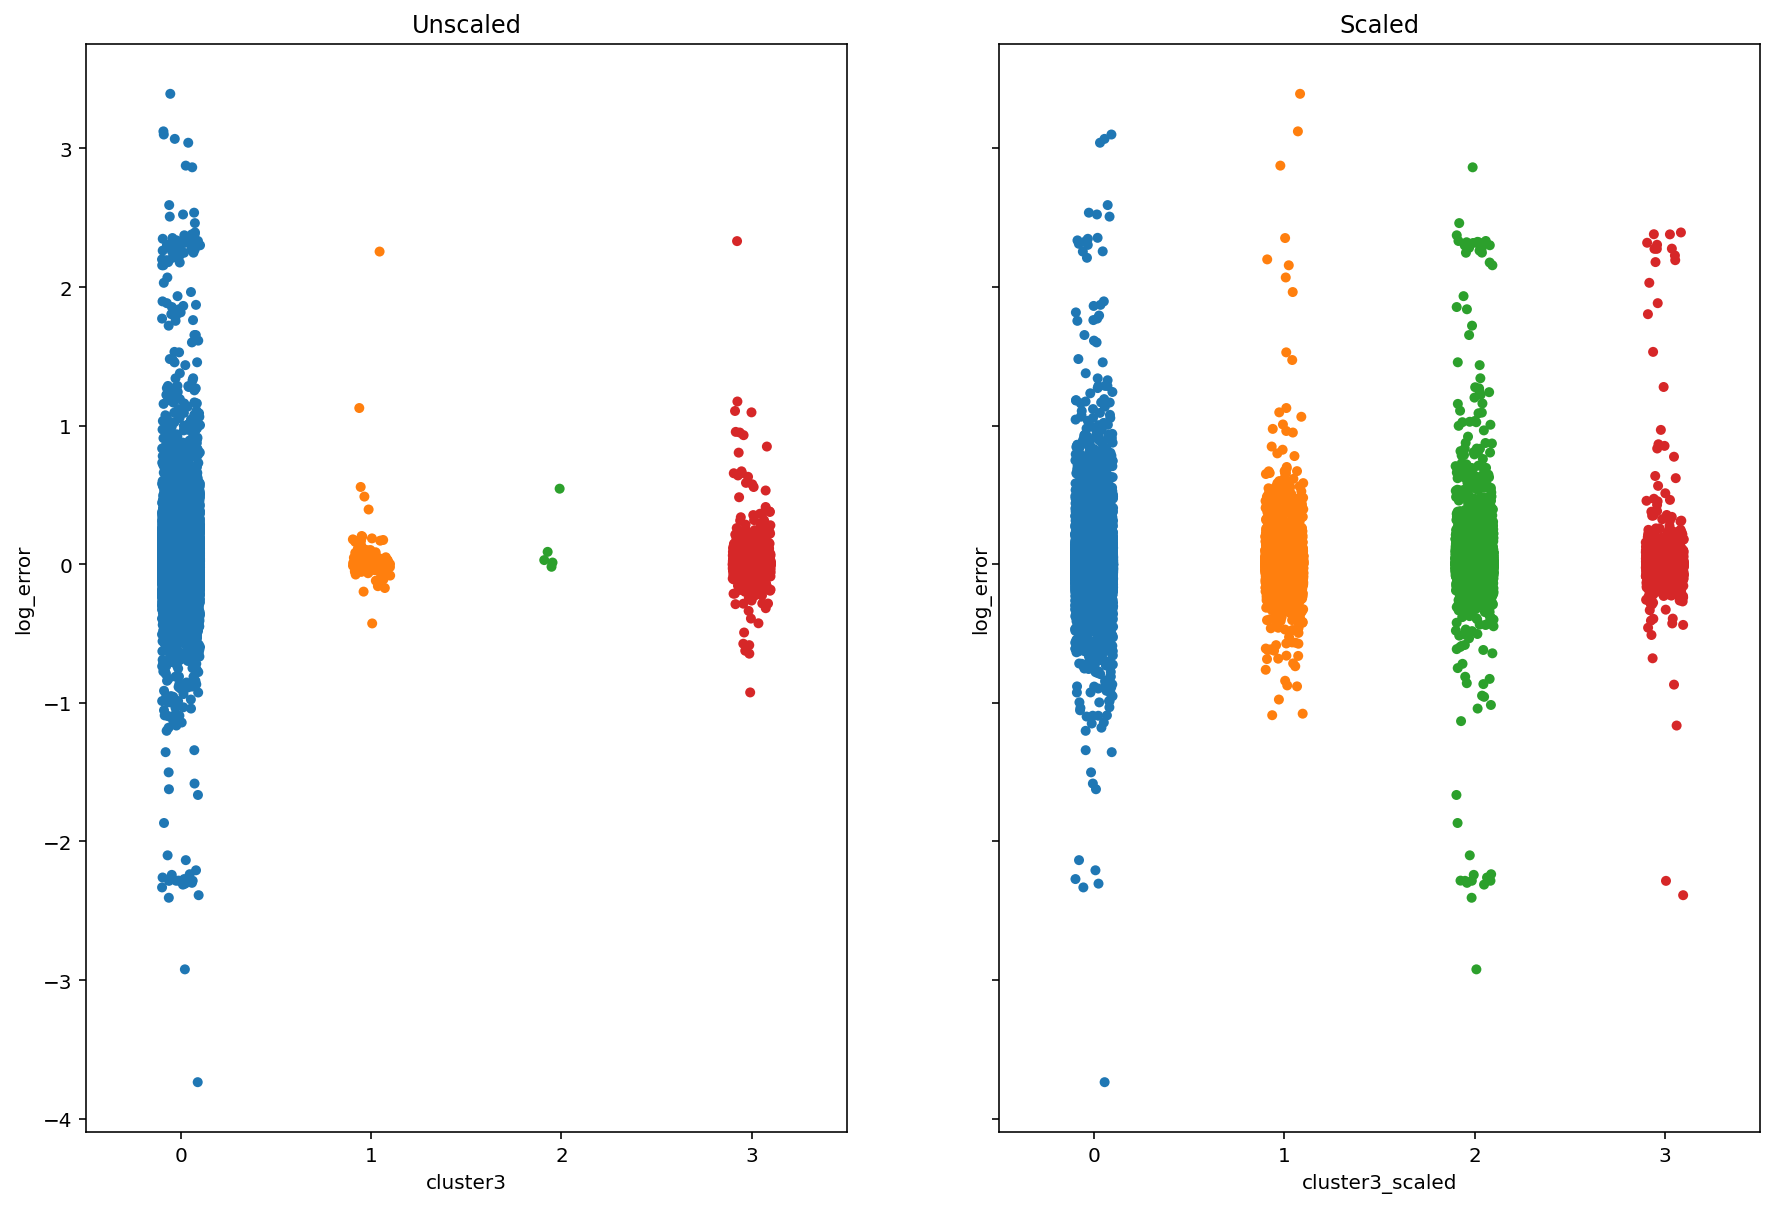

In [26]:
viz_for_Q3(df)

In [ ]:
# need to run a stat test to determine 

### creating and comparing clusters of features

In [27]:
all_features = train.columns

In [28]:
cluster_test =train.copy()

In [29]:
train.columns

Index(['parcel_id', 'bath_count', 'bed_count', 'calc_bath_and_bed',
       'calc_sqft', 'finished_sqft12', 'fips', 'fireplace_count',
       'full_bath_count', 'garage_car_count', 'latitude', 'longitude',
       'lot_sqft', 'pool_count', 'raw_census_tract_block', 'region_id_city',
       'region_id_county', 'region_id_zip', 'room_count', 'unit_count',
       'year_built', 'structure_tax_value', 'tax_value', 'assessment_year',
       'land_value', 'tax_amount', 'census_tract_and_block', 'log_error',
       'transaction_date', 'heating_system_desc', 'property_land_use_desc',
       'log_error_outliers', 'outliers', 'bound_group', 'cluster3'],
      dtype='object')

In [30]:
train.calc_bath_and_bed.isnull().sum()

342

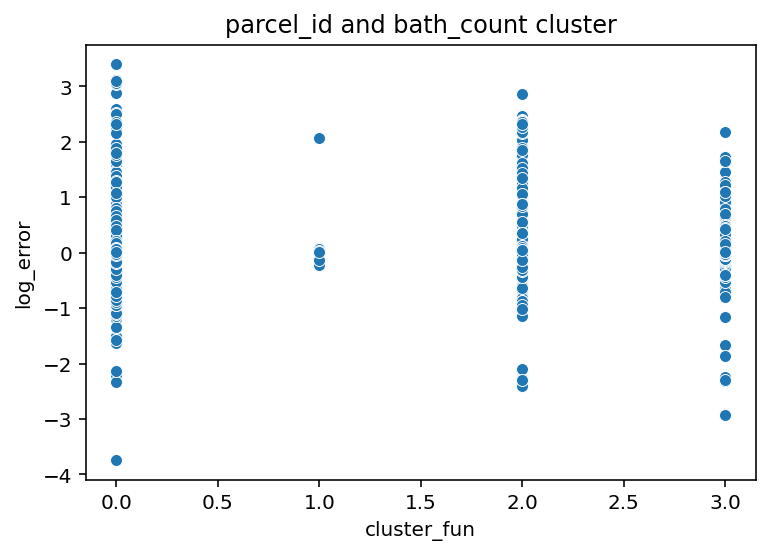

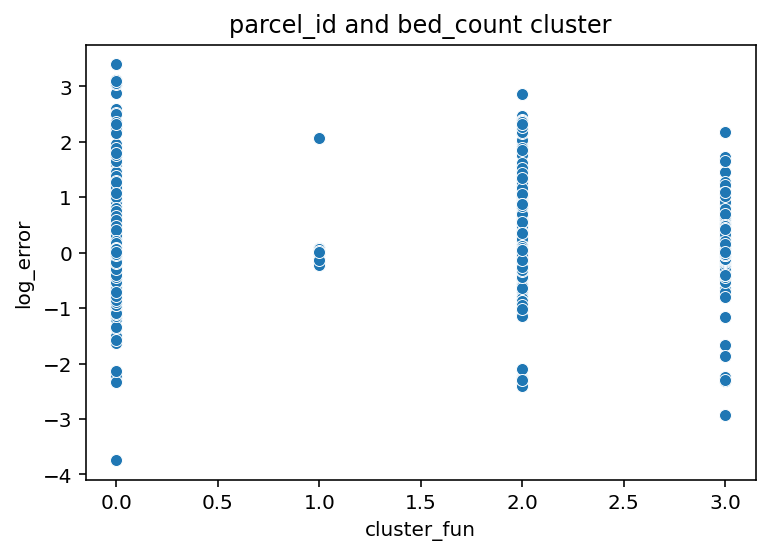

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [31]:
for feature in all_features:
    for feature2 in all_features:
        if feature != feature2: 
            cluster_fun = cluster_test[[feature, feature2]]

            #Fit a new model to my scaled data
            kmeans_scale = KMeans(n_clusters=4, random_state = 89)

            kmeans_scale.fit(cluster_fun)

            cluster_test['cluster_fun'] = kmeans_scale.predict(cluster_fun)
            plt.title(f'{feature} and {feature2} cluster')
            sns.scatterplot(y='log_error', x='cluster_fun',
                    palette='colorblind', data=cluster_test)
            plt.show()

In [ ]:
def viz_for_Q2(train_df):
    
    #unscaled data
    X2 = train_df[['tax_value', 'calc_sqft']]
    kmeans = KMeans(n_clusters = 4, random_state =89).fit(X2)
    train['cluster2'] = kmeans.predict(X2)
    
    #scaled data
    train_scaled2 = w.scale(train, ['tax_value', 'calc_sqft'])
    X2_scaled = train_scaled2[['scaled_tax_value', 'scaled_calc_sqft']]
    kmeans = KMeans(n_clusters = 4, random_state = 89).fit(X2_scaled)
    
    train_scaled2['cluster2_scaled'] = kmeans.predict(X2_scaled)
    train_scaled2['log_error'] = train['log_error']
    
    #viz 
    fig, axes= plt.subplots(1,2, figsize =(15, 10), sharey = True)
    fig.subtitle = ('Unscaled vs. Scaled')

    #Unscaled
    sns.stripplot(ax=axes[0], data = train, x = 'cluster2', y = 'log_error')
    axes[0].set_title('Unscaled')

    #Scaled
    sns.stripplot(ax = axes[1],data = train_scaled2, x = 'cluster2_scaled', y = 'log_error')
    axes[1].set_title('Scaled')
    
    plt.show()

In [ ]:
viz_for_Q2(train)